Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
path= "../"

import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
import copy
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import pickle
import os
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use(f'article.mplstyle')

In [2]:
all_df= pd.read_pickle(f"{path}output/pickle_results/real_data.pkl")

## Load results from competitors

In [3]:
sczi = pd.read_pickle(f"{path}output/pickle_results/real_data_sczi.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")

sczi = pd.read_pickle(f"{path}output/pickle_results/real_data_scanpy.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")

sczi = pd.read_pickle(f"{path}output/pickle_results/real_data_scDeepCluster.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")
all_df["cluster_number"] = all_df["cluster_number"].astype(int)

In [4]:
all_df["dataset"].unique()

array(['10X_PBMC', '10X_PBMC_select_2100', 'mouse_ES_cell',
       'mouse_ES_cell_select_2100', 'worm_neuron_cell_select_2100',
       'worm_neuron_cell', 'mouse_bladder_cell',
       'mouse_bladder_cell_select_2100'], dtype=object)

In [5]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}
order_dataset ={'10X PBMC': 0,
 '10X PBMC (2100)': 1,
 'Mouse ES\nCell': 2,
 'Mouse ES\nCell (2100)': 3,
 'Worm Neuron\nCell (2100)': 4,
 'Worm Neuron\nCell': 5,
 'Mouse Bladder\nCell': 6,
 'Mouse Bladder\n Cell (2100)': 7}

In [6]:
all_df["dataset"] = all_df["dataset"].apply(lambda x: dataset_names[x])

In [7]:
ours_basic = [
    'kmeans_representation_0', 'kmeans_representation_1',
    'kmeans_representation_2'
]
ours_clust = ['network_0', 'network_1', 'network_2']

df1 = all_df.sort_values(by="cluster_number")

columns = [
    'dataset', 'cluster_number', 'original', 'pca',
    'kmeans_representation_0', 'kmeans_representation_1',
    'kmeans_representation_2', 'network_0', 'network_1', 'network_2', 'sczi',
    'scanpy', 'scDeepCluster', 'COMBINED_kmeans', 'COMBINED_leiden'
]

df1 = df1[columns]

df1 = pd.melt(df1, id_vars=['dataset', 'cluster_number'])


def rename(x):
    if x in ours_basic:
        return "Baseline k-means"
    if x in ours_clust:
        return "Cluster NN"
    if x == 'COMBINED_kmeans':
        return "Ensemble K-means"
    if x == 'COMBINED_leiden':
        return "contrastive-sc"
    if x == "pca":
        return "PCA + KMeans"
    if x == "original":
        return "KMeans"
    return x

def order(x):
    if x == "PCA + KMeans":
        return 0
    if x == "KMeans":
        return 1
    if x == 'Seurat':
        return 3
    if x == 'scanpy':
        return 4
    if x == 'sczi':
        return 5
    if x == "scDeepCluster":
        return 6
    if x == "Baseline k-means":
        return 7
    if x == "Cluster NN":
        return 8
    if x == "Ensemble K-means":
        return 9
    if x == "contrastive-sc":
        return 10
    if x == "Ensemble Leiden (contrastive-sc)":
        return 10

    return x


df1["variable"] = df1["variable"].apply(rename)
df1 = df1[df1["variable"] != "remove"]
df1["order"] = df1["variable"].apply(order)

In [8]:
df1["dataset_order"] = df1["dataset"].apply(lambda x: order_dataset[x])

In [9]:
df1 = df1.sort_values(by=["dataset_order", "order"], ascending=True)

In [10]:
df1["dataset"].unique()

array(['10X PBMC', '10X PBMC (2100)', 'Mouse ES\nCell',
       'Mouse ES\nCell (2100)', 'Worm Neuron\nCell (2100)',
       'Worm Neuron\nCell', 'Mouse Bladder\nCell',
       'Mouse Bladder\n Cell (2100)'], dtype=object)

In [15]:
df1.groupby(["dataset", "variable"])[["value"]].mean().unstack("variable")

value                              \
variable                    Baseline k-means Cluster NN Ensemble K-means   
dataset                                                                    
10X PBMC                            0.461221   0.488055         0.588540   
10X PBMC (2100)                     0.403460   0.427568         0.585675   
Mouse Bladder\n Cell (2100)         0.288842   0.318243         0.397222   
Mouse Bladder\nCell                 0.297732   0.328283         0.383103   
Mouse ES\nCell                      0.570297   0.016423         0.656451   
Mouse ES\nCell (2100)               0.647027   0.659912         0.740503   
Worm Neuron\nCell                   0.303664   0.301926         0.429629   
Worm Neuron\nCell (2100)            0.218233   0.220345         0.438779   

                                                                  \
variable                      KMeans PCA + KMeans contrastive-sc   
dataset                                                            
10X PBMC                     0.57814     0.222070       0.627008   
10X PBMC (2100)              0.62993     0.340020       0.677475   
Mouse Bladder\n Cell (2100)  0.36022     0.394420       0.576974   
Mouse Bladder\nCell          0.40146     0.366040       0.546637   
Mouse ES\nCell               0.72291     0.753120       0.657683   
Mouse ES\nCell (2100)        0.88681     0.747770       0.631700   
Worm Neuron\nCell            0.08392     0.190820       0.352147   
Worm Neuron\nCell (2100)     0.04622     0.185043       0.358964   

                                                               
variable                    scDeepCluster    scanpy      sczi  
dataset                                                        
10X PBMC                          0.50718  0.558179  0.590273  
10X PBMC (2100)                   0.42047  0.575841  0.606740  
Mouse Bladder\n Cell (2100)       0.41084  0.616216  0.515573  
Mouse Bladder\nCell               0.41728  0.639034  0.443520  
Mouse ES\nCell                    0.83705  0.776260  0.800450  
Mouse ES\nCell (2100)             0.84893  0.773215  0.797203  
Worm Neuron\nCell                 0.26283  0.405174  0.063557  
Worm Neuron\nCell (2100)          0.19583  0.420854  0.200320

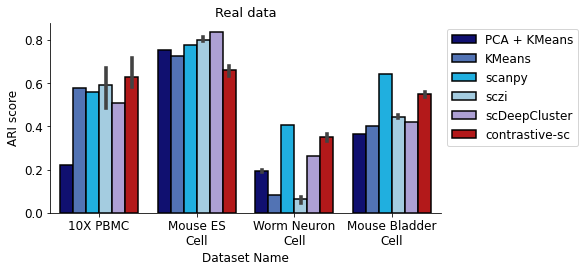

In [13]:
methods = [
    'PCA + KMeans', 'KMeans', 'scanpy', 'sczi', 'scDeepCluster',
    'contrastive-sc'
]
datasets = [
    '10X PBMC', 'Mouse ES\nCell', 'Worm Neuron\nCell', 'Mouse Bladder\nCell'
]
plt.figure(figsize=(7, 3.5))
ax = plt.gca()
clrs = ['navy', '#416ec5', 'deepskyblue', '#9acfea', "#a897dd", '#cc0001']
sns.barplot(
    data=df1[df1["variable"].isin(methods) & df1["dataset"].isin(datasets)],
    x="dataset",
    y="value",
    hue="variable",
    palette=clrs,
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.xlabel("Dataset Name")
plt.ylabel("ARI score")
plt.title(f"Real data")
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig(f"{path}diagrams/real.pdf", bbox_inches='tight')

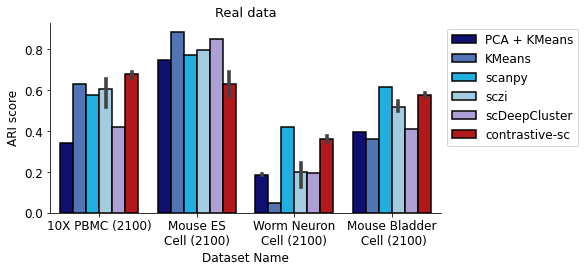

In [14]:
methods = [
    'PCA + KMeans', 'KMeans', 'scanpy', 'sczi', 'scDeepCluster',
    'contrastive-sc'
]
datasets = [
    '10X PBMC (2100)', 
       'Mouse ES\nCell (2100)', 'Worm Neuron\nCell (2100)',
       'Mouse Bladder\n Cell (2100)'
]
plt.figure(figsize=(7, 3.5))
ax = plt.gca()
clrs = ['navy', '#416ec5', 'deepskyblue', '#9acfea', "#a897dd", '#cc0001']
sns.barplot(
    data=df1[df1["variable"].isin(methods) & df1["dataset"].isin(datasets)],
    x="dataset",
    y="value",
    hue="variable",
    palette=clrs,
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.xlabel("Dataset Name")
plt.ylabel("ARI score")
plt.title(f"Real data")
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig(f"{path}diagrams/real_2100.pdf", bbox_inches='tight')

In [14]:
df1.to_pickle(f"{path}output/real.pkl")